# IML Project
### Yanis Farhat et Benjamin Clene
#### Projet effectué en pair programming

Le but de ce project est d'obtenir un classifieur de pixels.

Pour ce faire on a notre dispositions deux images. Une image hyperspectrale et une image lidar.

Dans ce notebook nous aller creer un model et l'entrainer sur une partie de l'image hyperspectrale et une partie de l'image lidar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import io

D'abord nous allons importer les données pour entrainer le modele.

In [2]:
data = sp.io.loadmat('data/2013_DFC_contest.mat')

lidar = data['lidar'].copy()
print("L'image LiDAR est composée de %d lignes et %d colonnes "%(lidar.shape)+"au format %s"%lidar.dtype)
hsi_raw = data['hyper'].copy()
print("L'image hyperspectrale est composée de %d lignes, %d colonnes et %d bandes "%(hsi_raw.shape)
      +"au format %s"%hsi_raw.dtype)

L'image LiDAR est composée de 349 lignes et 1905 colonnes au format float32
L'image hyperspectrale est composée de 349 lignes, 1905 colonnes et 144 bandes au format uint16


Ensuite on charge la vériter terrain

In [3]:
groundtruth = np.load('groundtruth/groundtruth.npy')
groundtruth_info = np.load('groundtruth/groundtruth_info.npy',allow_pickle=True)
groundtruth_rgb = plt.imread('groundtruth/groundtruth.png')

In [4]:
groundtruth_info

array([{'class_name': 'grass_healthy', 'class_label': 1, 'class_color': array([  0, 205,   0], dtype=int64)},
       {'class_name': 'grass_stressed', 'class_label': 2, 'class_color': array([127, 255,   0], dtype=int64)},
       {'class_name': 'grass_synthetic', 'class_label': 3, 'class_color': array([ 46, 205,  87], dtype=int64)},
       {'class_name': 'tree', 'class_label': 4, 'class_color': array([  0, 139,   0], dtype=int64)},
       {'class_name': 'soil', 'class_label': 5, 'class_color': array([160,  82,  45], dtype=int64)},
       {'class_name': 'water', 'class_label': 6, 'class_color': array([  0, 255, 255], dtype=int64)},
       {'class_name': 'residential', 'class_label': 7, 'class_color': array([255, 255, 255], dtype=int64)},
       {'class_name': 'commercial', 'class_label': 8, 'class_color': array([216, 191, 216], dtype=int64)},
       {'class_name': 'road', 'class_label': 9, 'class_color': array([255,   0,   0], dtype=int64)},
       {'class_name': 'highway', 'class_label':

On prepare les données hsi avant qu'elles ne soient normalisées pour pouvoir visualser image original plus tard

In [5]:
rgb_bands = [54,32,18]
hsi_rgb = hsi_raw[:,:,rgb_bands]
hsi_rgb = hsi_rgb/hsi_rgb.max() # normalisation des valeurs dans [0,1] pour l'affichage
pmin,pmax = np.percentile(hsi_rgb,(1,95),axis=(0,1))
hsi_rgb_pimped = hsi_rgb.copy()
for i in range(pmin.size):
    hsi_rgb_pimped[:,:,i] = (hsi_rgb[:,:,i]-pmin[i])/(pmax[i]-pmin[i])
hsi_rgb_pimped[hsi_rgb_pimped<0] = 0
hsi_rgb_pimped[hsi_rgb_pimped>1] = 1

On normalise les données, on arrive à de meilleurs resultats avec cette normalisation

In [6]:
#normalize hsi_raw
hsi_raw = hsi_raw.astype(np.float64)
for i in range (hsi_raw.shape[0]):
    for j in range(hsi_raw.shape[1]):
        X = hsi_raw[i][j]
        if np.any(X != 0):
            hsi_raw[i][j] = (X - X.min()) / (X.max() - X.min())

#normalize lidar
lidar = lidar.astype(np.float64)
lidarMin = lidar.min()
lidarMax = lidar.max()
for i in range (lidar.shape[0]):
    for j in range(lidar.shape[1]):
        X = lidar[i][j]
        if np.any(X != 0):
            lidar[i][j] = (X - lidarMin) / (lidarMax - lidarMin)

On prepare les données de test en fusionnant les donénes lidar et hyperspectrales

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


hsi_raw = hsi_raw
lidar = lidar
r,c,N = hsi_raw.shape
hsi = hsi_raw.reshape(r*c,N)

#fusion lidar and hsi for the whole image
allData = np.concatenate((hsi, lidar.reshape(-1, 1)), axis=1)

# we take only pixels with a grountruth known
hsi_train = hsi_raw[groundtruth != 0]
lidar_train = lidar[groundtruth != 0]

# fusion lidar and hsi sets
x_train = np.concatenate((hsi_train, 10*lidar_train.reshape(-1, 1)), axis=1)
y_train = groundtruth[groundtruth != 0]

#check shapes
allData.shape, hsi_train.shape, lidar_train.shape, x_train.shape, y_train.shape

((664845, 145), (2832, 144), (2832,), (2832, 145), (2832,))

On creer un set de données de validation a partir du set de données d'entrainement

In [8]:
#### from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

On entraine un modele de type RandomForestClassifier car il obtient le meilleur score.

Le score varie en fonction de la repartition des données par la fonction train_test_split.

In [9]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


classifier = RandomForestClassifier(max_depth=16, random_state=1, n_estimators=50, n_jobs=-1)
classifier = classifier.fit(x_train, y_train)
score = classifier.score(x_val, y_val)

print("score: ", score)

score:  0.9294532627865961


Enfin, on predit a l'aide du model tout les pixels de l'image et on compare avec l'image d'origine

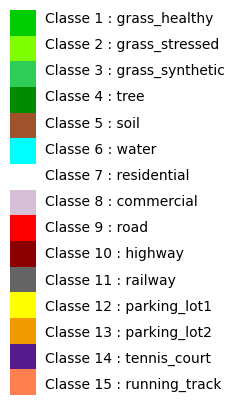

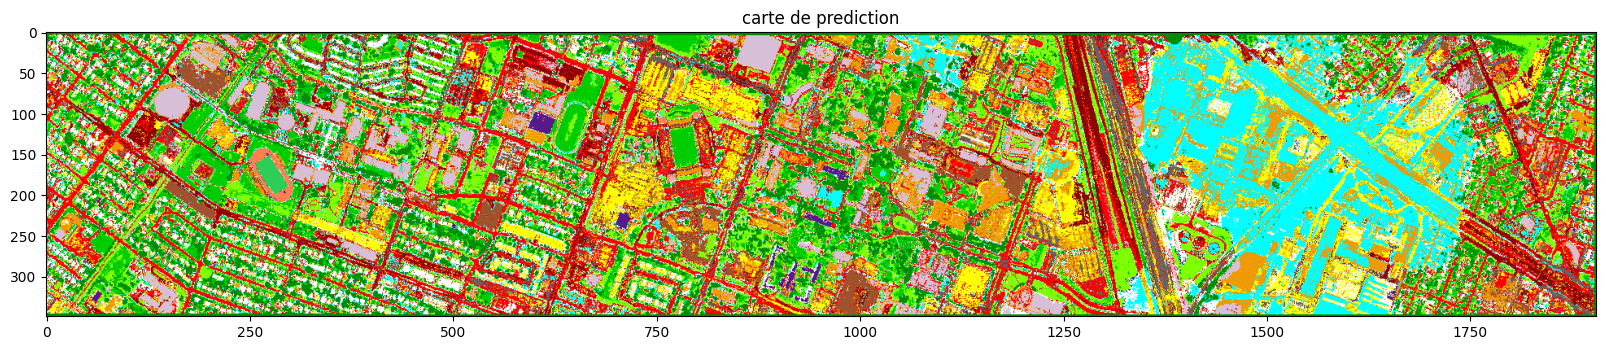

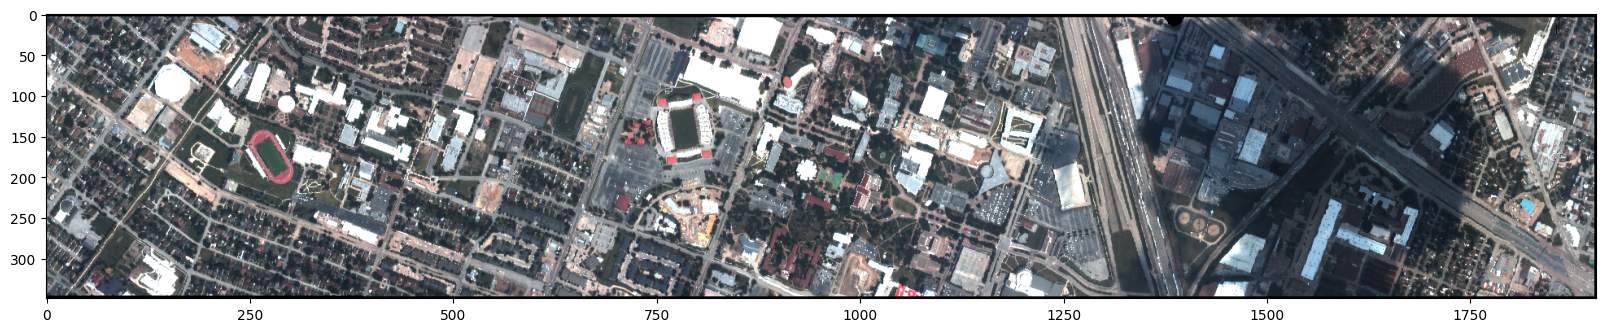

In [10]:
# predict for the whole image
prediction = classifier.predict(allData)
predictionRgb = np.zeros(shape=(prediction.shape[0], 3))

cls_rgb = []
for ii in groundtruth_info:
    cls_rgb.append(ii['class_color'])
cls_rgb = np.array(cls_rgb).reshape(15,-1,3)
plt.figure(figsize=(5,5))
plt.imshow(cls_rgb)
plt.axis('off')
for cls in range(15):
        plt.text(0.85,1.02*cls,'Classe %d : %s'%(cls+1,groundtruth_info[cls]['class_name']))
plt.show()

for i in range(len(prediction)):
    predictionRgb[i] = cls_rgb[prediction[i]-1]
predictionRgb = predictionRgb.astype(np.uint)

plt.figure(figsize=(20,5))
plt.title('carte de prediction')
plt.imshow(predictionRgb.reshape((349,1905,3)))
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(hsi_rgb_pimped)
plt.show()

# Dans ce projet nous devions traiter l'image pour retirer la tache du nuage presente dans les données hyperspectrales, ce code est une tentative de réecriture de l'algorithme :

https://www.researchgate.net/publication/321793889_Hyperspectral_cloud_shadow_removal_based_on_linear_unmixing

cette cellule n'est pas executable.

In [11]:
#cette partie est censée enlever la tache du nuage, malheureseument l'algorithme ne fonctionne pas
from sklearn.decomposition import FastICA

def find_endmembers(X, n_endmembers):
    """
    Find the endmembers in the hyperspectral image.
    This uses the FastICA algorithm to find the endmembers,
    which is a form of independent component analysis.
    """
    ica = FastICA(n_components=n_endmembers)
    S_ = ica.fit_transform(X)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix

    return A_

def linear_unmixing(Y, X, h, Ethr):
    #initialization of variables
    i = 0
    E = np.inf
    M = X
    C = np.identity(144)
    Zab = np.ones((X.shape[1],Y.shape[1]))
    Z = 0
    alpha = 0
    
    #algo
    while i < 144 or E <= Ethr :
        # step 1, estimate Z
        Z = np.argmin(0.5*np.linalg.norm(np.dot(M,Zab)-Y))
        
        #step 2, estimate alpha
        alpha = np.dot(np.dot(np.dot(np.subtract(Y[:,:2],np.dot(np.dot(C,X),Z)),Z.T),h),np.linalg.inv(h.T*Z*Z.T*h))
        
        #step 3, estimate C
        A = Y-alpha*h.T*Z
        B = X*Z
        C = np.zeros(144)
        for j in range(0,144):
            C[j] = (A[i]*B.T[i])/np.linalg.norm(B[i])
        M = alpha*h.T + C*X
        E = np.linalg.norm(Y-M*Z)
        i = i+1
    return Z

# Load your hyperspectral image data into X
# X should be a 2D numpy array where each row is a pixel and each column is a band
# For example:
X = data["hyper"].copy()
r,c,N = X.shape
X = X.reshape(r*c, N)
print(X.shape)

# Find the endmembers
# n_endmembers is the number of endmembers you want to find
# For example:
n_endmembers = 2
endmembers = find_endmembers(X, n_endmembers)

# Perform linear unmixing to estimate the abundance of each endmember
h = np.ones((endmembers.shape[1],1))
Ethr = 9999999
abundances = linear_unmixing(X.T, endmembers, h, Ethr)

(664845, 144)


C:\Users\yanis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


LinAlgError: Singular matrix

# Export des données

In [12]:
prediction = prediction.reshape(349,1905)

In [14]:
# Sanity check 1: do predictions have the correct shape?
assert(prediction.shape == groundtruth.shape)

In [15]:
# Sanity check 2: are predicted values in the correct domain?
assert(np.all(np.in1d(prediction.flatten(), np.unique(groundtruth))))

In [28]:
# Export
import os.path
filename_predictions = "predictions.npz"
np.savez_compressed(filename_predictions, data=prediction)
assert(os.path.exists(filename_predictions))

In [29]:
# Sanity check 3: read file again and check its content is consistent
loaded_data = np.load(filename_predictions)['data']
assert(np.allclose(loaded_data, prediction))